# Variational Quantum Deflation for excited states of molecules

#### Das Pemmaraju, IBM CODAIT, San Jose

## Introduction

The simulation of excited states of molecular systems is an important task in quantum chemistry with relevance to technologies such as solar energy harvesting, catalysis, optoelectronics, and many others. Quantum computing protocols for accessing molecular excited state properties are therefore currently under active investigation [1–11]. In the NISQ era, approaches based on the Variational Quantum Eigensolver (VQE)[12] algorithm are of particular interest for their ability to represent useful quantum states on near term quantum devices using parameterized quantum circuits while offloading the optimization of the parameters specifying the quantum circuit to classical hardware. The hybrid quantum-classical paradigm implied by VQE and generalizations thereof has therefore undergone rapid development since 2014 [13]. Today most quantum computing platform APIs provide VQE solvers which can be deployed for computing ground state total energies of molecular systems using only a few lines of python code. Excited state solvers such as qEOM [6] are also available as user-friendly implementations [14] and certainly more will be implemented by platform providers in the near future. 

In this notebook, we will look at a simple extension of VQE to excited states known as Variational Quantum Deflation (VQD)  [11] which allows for the sequential computation of excited states with circuit depths that are comparable to ground state simulations. The method also allows for easy incorporation of additional constraints to target specific symmetry sectors. The demonstration follow the general approach outlined in the original paper by Higgott et al [11]. The focus of this tutorial is on the algorithm itself  and not on a specific NISQ hardware implementation which may require additional work. Hence, we will confine ourselves to abstraction layers such as the Operator Flow (opflow) [15] layer of IBM Qiskit [16] which offers a convenient language quantum mechanics practitioners can work with. For general background on Qiskit and VQE in the context of quantum chemistry, readers are referred to source materials on Qiskit-Nature [17].

## Outline of VQD

The Variational Quantum Deflation (VQD) algorithm [11] exploits the mutual orthogonality of the eigenstates of a Hermitian operator, in our case the Hamiltonian, to systematically find excited states using a constrained optimization approach. The necessary orthogonality constraint is introduced in the form of an $\textit{overlap}$ penalty term in the cost function which is to be variationally optimized using a parameterized circuit ansatz. Concretely, while in VQE for ground states we vary the circuit parameters $\theta$ to minimize the expectation 

$E(\theta) \equiv \langle \psi(\theta) | H | \psi(\theta) \rangle$ 

of the Hamiltonian $H$, in VQD, the more general cost function 

$F(\theta_k) \equiv \langle \psi(\theta_k) | H | \psi(\theta_k) \rangle + \sum_{i=0}^{k-1} \beta_i |\langle \psi(\theta_k) | \psi(\theta_i) \rangle |^2 $

is minimized for each excited state $|\psi(\theta_k)\rangle$ of interest. The second term on the right hand side is the overlap penalty term that enforces approximate orthogonality of the target state $|\psi(\theta_k)\rangle$ with respect to every other previously identified eigenstate $|\psi(\theta_i)\rangle$. For appropriately chosen  multipliers $\beta_i$, the minimum of the cost function $F(\theta_k)$ yields the energy of the state $|\psi(\theta_i)\rangle$ as shown by Higgott et al [11]. 

Given the above, there are a few implementation details we need to consider: 
#### (i) Overlap estimation 
Since our variational ansatz states are of the form 

$|\psi(\theta_k) \rangle \equiv U(\theta_k) |0\rangle$

specified by parameterized unitaries $U(\theta_k)$, for the overlap penalty term, we can directly estimate 

$|\langle \psi(\theta_i) | \psi(\theta_k) \rangle |^2 = |\langle 0 | U(\theta_i)^{\dagger} U(\theta_k) |0 \rangle |^2  = \langle 0 | U(\theta_k)^{\dagger} U(\theta_i) |0 \rangle \langle 0 |U(\theta_i)^{\dagger} U(\theta_k) |0 \rangle $

which amounts to measuring the expectation value of the $n$-qubit projection operator $|0\rangle\langle0|$ in the state $U(\theta_i)^{\dagger} U(\theta_k) |0 \rangle $. We implement this below using Qiskit's opflow. As noted by Higgott et al [11] inverting the circuit describing $U(\theta_i)$ only leads to an approximation of $U(\theta_i)^{\dagger}$ which maybe variationally optimized separately where high precision is needed. 
#### (ii) Storage of optimal parameters $\lbrace \theta_i \rbrace$
Since finding the state $|\psi(\theta_k)\rangle$ requires knowledge of all preceding eigenstates specified by $\theta_0, \theta_1, ..., \theta_{k-1}$, the parameter set $\lbrace \theta_i \rbrace$ needs to be stored for on-the-fly retrieval within an iterative scheme. This is not a problem however since our working assumption is that the parameterization is compact enough to be stored in classical RAM while yielding circuits expressive enough to approximate useful quantum states. In the implementation below we store the optimal parameters simply as numpy arrays and use them not only within an excited state search at a given molecular geometry but also to provide starting guess parameters in a potential energy surface calculation.
#### (iii) Choice of circuit ansatz
Since the primary goal of this exercise is to reproduce the main result of Figure 2 from the original VQD paper [11], we employ the generic UCCGSD [18] variant of the unitary coupled cluster (UCC) ansatz which is the same circuit ansatz used in [11]. Conveniently, UCCGSD is already implemented in Qiskit. One can of course explore other variations of circuit ansatze on top this basic implementation. Note that we use two Trotter iterations with the UCC ansatz as it is found empirically that a single Totter step may not lead to expressive enough circuits for excited states.

### Implementation for State Vector Simulators

We start with some necessary imports.

In [1]:
import numpy as np
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.properties.second_quantization.electronic import ElectronicEnergy, ParticleNumber, AngularMomentum, Magnetization, DipoleMoment
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

from qiskit_nature.circuit.library import UCCSD, HartreeFock, initial_states

from qiskit.algorithms.optimizers import SPSA
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit.opflow import SummedOp, StateFn, PrimitiveOp

The **VQD** class as defined below handles the tasks necessary to carry out the iterative VQD excited state search given a qubit Hamiltonian, a circuit wavefunction ansatz and a specified number of excited states. This class therefore requires a set of qubit operators and a circuit wavefunction ansatz to be provided at instantiation time where we set up necessary storage and specify the backend associated with simulating the circuits. 

The **get_overlap** function calculates the overlap between ansatz states using the n-qubit $|0\rangle\langle0|$ projector as outlined above.  

The **get_expectation** function simply measures the expectation of a diagonal measurement given a set of parameters specifying an ansatz state. 

Both functions use the Qiskit opflow syntax.

The **cost_fun_gen** function puts together the VQD cost function expression and includes a loop for calculating  overlaps between the target state and all previous eigenstates. 

The **calculate function** loops over each of the requested target states and calls the classical optimizer (P_BFGS in this case) to refine the parameters for each eigenstate.

In [2]:
from qiskit.opflow import StateFn, ExpectationFactory, CircuitStateFn, ListOp, CircuitSampler
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus, PauliExpectation
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.optimizers import P_BFGS, L_BFGS_B, NELDER_MEAD, COBYLA
import numpy.random as npr
import scipy.linalg as sl
from scipy.optimize import minimize

class VQD:
    
    def __init__(self, qOps, wfnA, nEx, states=np.array([])):
        self.qOps = qOps
        self.wfnA = wfnA
        self.nEx = nEx
        self.states = states
        
        hq_op = self.qOps[0]  #Hamiltonian
        
        #Construct the n-qubit |0><0| projection operator needed for overlap estimation using opflow .
        Qp = (1/2) * ( I + Z )
        self.zProj = Qp
        for iq in range(1, hq_op.num_qubits):
            self.zProj ^= Qp

        #Recast the wavefunction ansatz to a CircuitStateFn for opflow
        self.wf_circ_op = CircuitStateFn(wfnA)
                   
        self.backend = AerSimulator(device='CPU', blocking_enable=True, method='statevector', batched_shots_gpu=True)
        
        expectation = ExpectationFactory.build(operator=hq_op,backend=self.backend,include_custom=True)
        observable_meas = expectation.convert(StateFn(hq_op, is_measurement=True))
        self.expect_op = observable_meas.compose(self.wf_circ_op).reduce()
        
        exp_proj = ExpectationFactory.build(operator=self.zProj,backend=self.backend,include_custom=True)
        self.proj_meas = exp_proj.convert(StateFn(self.zProj, is_measurement=True))
        
        if not self.states.any():
            self.wfn_params = np.eye(len(wfnA.parameters), nEx+1)
        else:
            self.wfn_params = self.states
        self.nFound = 0
        self.LagM = 3.0*np.ones(nEx)
        self.optimizer = P_BFGS(maxfun=2000, ftol=0.000001, iprint=-1, max_processes=12)
        self.fcount = 0
        self.curr_state = 0
        self.eigenvals = []

    def get_overlap(self, wfn_anz, p_dict1, p_dict2):
        """
        Function to calculate state overlap <state2 | state1> using OpFlow
        ----Parameters----
        wfn_anz: A parameterized circuit StateFn ansatz with unbound parameters
        p_dict1: A dictionary of paramers to bind to obtain state1
        p_dict2: A dictionary of paramers to bind to obtain state2
        """
        state1 = wfn_anz.bind_parameters(p_dict1)
        state2 = wfn_anz.bind_parameters(p_dict2)
        state = CircuitStateFn(state1.compose(state2.inverse()))
        exp_ovlp = self.proj_meas.compose(state).reduce()
        return exp_ovlp.eval()
    
    def get_expectation(self, Mobj, p_dict):
        """
        Function to calculate expectation values using OpFlow
        ----Parameters----
        Mobj: An OpFlow diagonal measurement object with unbound parameters
        p_dict: A dictionary of paramers to bind
        """
        #Bind all relevant parameters
        expects = Mobj.bind_parameters(p_dict)
        
        #Call the eval function on the bound expectation object to get the results
        res = expects.eval()
        return res    
    
    def cost_fun_gen(self, params):
        """
        Function that evalues the cost function for deflation
        ----Parameters-----
        params: parameters of the wf circuit ansatz as a list
        """
        # Create a params dict from the provided list
        p_vec = list(self.wf_circ_op.parameters)[0].vector
        p_dict = {p_vec: params}

        # Evaluate the Hamiltonian expectation value for the current parameter set using the saved diag measrement obj
        ev = self.get_expectation(self.expect_op, p_dict)
        pen = 0
        for i in range(self.nFound):
            params_i = (self.wfn_params[:,i])
            p_dict_i = {p_vec: params_i}
            ovlp = self.get_overlap(self.wfnA, p_dict, p_dict_i)
            pen += self.LagM[0] * np.abs(ovlp)
            
        cost = np.real(ev) +  pen
        
        self.fcount += 1
        if self.fcount%50 == 0:
            print(f'cost, ev, pen is: {cost, ev, pen}')
        return cost
    
    def calculate(self):
        #start with the 0th exciated state i.e. ground state
        for iex in range(self.nEx+1):
            self.curr_state = iex
            if self.states.any():
                p0 = self.states[:,iex]
            else:
                if iex == 0:
                    p0 = self.wfnA.preferred_init_points
                else:
                    p0 = (np.pi/2) * np.random.rand(len(self.wfnA.preferred_init_points))
                
            bounds = [(-2 * np.pi, 2 * np.pi)] * len(self.wfnA.parameters)
            res = self.optimizer.minimize(fun=self.cost_fun_gen, x0=p0, jac=None, bounds=bounds)
            eigenval = res.fun
            eig_params = res.x
            self.nFound += 1
            if self.nEx >= iex:
                self.wfn_params[:,iex] = eig_params
            print(f'index, eigenValue, eigenVector:{iex, eigenval, eig_params}')
            self.eigenvals.append(eigenval)
        return (self.eigenvals, self.wfn_params)
        

The **ExcitedStateCalculator** class defined below handles the tasks associated with setting up the qubit operators and circuit state ansatz for a specified molecular geometry at instantiation time. 

It provides a **quantum_solve** function which makes use of the VQD class defined above to perform a VQD excited state search for with the chosen qubit operators and circuit state ansatz.

A convenience function **classical_solve** is also provided which diagonalizes a matrix representation of the specified qubit Hamiltonian using SciPy to yield exact results we can compare against VQD.

In [3]:
class ExcitedStateCalculator:
    def __init__(self, geometry):
        self.geometry = geometry
        # define molecule
        self.mol = Molecule(geometry=geometry, charge=0, multiplicity=1)

        # specify PYSCF classical driver
        self.driver = ElectronicStructureMoleculeDriver(self.mol, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)

        # run the classical SCF driver
        self.mf_result = self.driver.run()  
        
        # get particle number
        self.mf_energy = self.mf_result.get_property(ElectronicEnergy)
        self.particle_number = self.mf_result.get_property(ParticleNumber)
        self.num_electrons = self.particle_number.num_particles
        self.num_spin_orbitals = self.particle_number.num_spin_orbitals
        self.num_molecular_orbitals = int(self.num_spin_orbitals//2)
        
        #specify active space transformation (not needed for this example)
        active_space_trafo = ActiveSpaceTransformer(num_electrons=self.num_electrons, 
                                                    num_molecular_orbitals=self.num_molecular_orbitals)

        # define electronic structure problem
        self.es_problem = ElectronicStructureProblem(self.driver, transformers=[active_space_trafo])   
        
        #specify a quibit mapping (Jordan Wigner) of second quantized operators
        qubit_converter = QubitConverter(JordanWignerMapper(), two_qubit_reduction=False)
        
        #specify a HartreeFock initial state 
        hf_init = HartreeFock(self.num_spin_orbitals, self.num_electrons, qubit_converter)
        
        #instantiate a generalized UCCGSD ansatz circuit with 2 Trotter steps.
        self.wf_ansatz = UCCSD(qubit_converter=qubit_converter, num_particles=self.num_electrons, 
                               num_spin_orbitals=self.num_spin_orbitals, reps=2, initial_state=hf_init, 
                               preserve_spin=False, generalized=False)

        #perform the Fermion to qubit mapping of second quantized operators 
        self.q_ops = qubit_converter.map(self.es_problem.second_q_ops())
        
        
    def quantum_solve(self, num_excited_states, guess_state_parameters=np.array([])):
        print(self.wf_ansatz)
        vqdi = VQD(self.q_ops, self.wf_ansatz, num_excited_states, states=guess_state_parameters )
        (eigenvalues, result_states) = vqdi.calculate()
        #add nuclear repulsion to electronic energy
        eigenvalues = [ x + self.mf_energy.nuclear_repulsion_energy for x in eigenvalues ]
        return (eigenvalues, result_states)
    
    def classical_solve(self, num_excited_states):
        #Extract relevant qubit operators
        hq_op = self.q_ops[0]  #Hamiltonian
        nq_op = self.q_ops[1]  #Number operator
        
        #extract matrix representations of qubit operators
        H_Mat = hq_op.to_matrix()
        N_Mat = nq_op.to_matrix()
        
        #diagonalize to extrant eigen energies and eigenfunctions
        omega, psi = sl.eigh(H_Mat)
        
        #evaluate matrix elements of operators in eigenbasis
        N_expect = np.dot(psi.conj().T,np.dot(N_Mat, psi))
        E_expect = np.dot(psi.conj().T,np.dot(H_Mat, psi))
        
        #collect energies corresponding to states with the correct number of electrons
        c_eigs = []
        for i in range(N_Mat.shape[0]):
            if abs(N_expect[i,i] - np.sum(self.num_electrons)) < 1e-8:
                c_eigs.append(E_expect[i,i] + self.mf_energy.nuclear_repulsion_energy)
        c_eigs = np.real(np.array(c_eigs))
        return np.sort(c_eigs)[0:num_excited_states+1]
        

Having defined the VQD and ExcitedStateCalculator classes above we are now ready to execute a simple loop over molecular geometries to generate ground and excited state potential energy surfaces (PES) for reproducing Figure 2 of the VQD paper [11]. 

Accordingly, we choose the **H$_2$** molecule in the **sto-3g** minimal basis set to set up a **4 qubit VQD** problem and loop over bond distances to generate the PES. There are a total of ${4 \choose 2} = 6$ eigenstates with particle number 2 or 5 $\textit{excited}$ states to calculate. 

In [4]:
n_excited_states=5
counter = 0
geom_vs_energies = []

restart = False

if not restart:
    states_history = []  #store these in case we need to re-start
    
for bond_distance in [ 0.3 + i*0.1 for i in range(12) ] + [ 1.5 + i*0.2 for i in range(6) ]:
    #define molecular geometry 
    geometry = [["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]]
    
    #instantiate the solver
    
    pes = ExcitedStateCalculator(geometry)
        
    if (not restart) and counter == 0:
        (eigenvalues, result_states) = pes.quantum_solve(n_excited_states, guess_state_parameters = np.array([]) )
    else:
        if restart:
            result_states = states_history[counter]
        (eigenvalues, result_states) = pes.quantum_solve(n_excited_states, guess_state_parameters = result_states)

    geom_vs_energies.append((bond_distance, eigenvalues))
    states_history.append(result_states)
    
    counter += 1

print(geom_vs_energies)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen is: (-2.365727747165606, (-2.365727747165606-0j), 0)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -2.3657277471656055, array([ 1.53818047e-08,  1.75402039e-08,  9.16932282e-09, -1.97401787e-08,
        2.47776977e-02, -1.74374540e-08, -3.54645916e-08,  2.08674946e-09,
       -9.16932282e-09,  2.47776875e-02]))
cost, ev, pen is: (-0.9259798672487486, (-0.9261852887107842+0j), 0.000205421462035578)
cost, ev, pen is: (-0.9278483351597715, (-0.9278483458444522+0j), 1.0684680642e-08)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.9278484479031791, array([0.98861994, 0.84599145, 0.4945877 , 0.43010414, 0.30394472,
       1.59692164, 0.97020682, 1.18357191, 0.55064213, 0.15411245]))
cost, ev, pen is: (-0.3043421611818402, (-1.3163153434073478-0j), 1.0119731822255076)
cost, ev, pen is: (-0.8846495343591432, (-0.8858701381776285-0j), 0.001220603818485366)
cost, ev, pen is: (-0.9277571372982635, (-0.9277768559454662+0j), 1.9718647202685e-05)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.9278484432694801, array([ 3.28037267,  1.33930851,  1.40369305, -0.42035135,  1.20699859,
        2.37130079,  1.63148844,  0.43195794, -2.34622483,  1.41169854]))
cost, ev, pen is: (0.38186710249334643, (-0.9902427522985657+0j), 1.3721098547919122)
cost, ev, pen is: (-0.8966408643273348, (-0.8983905166170243+0j), 0.0017496522896894998)
cost, ev, pen is: (-0.9268752274823988, (-0.9277012226047969+0j), 0.0008259951223981139)
cost, ev, pen is: (-0.9278484485002625, (-0.9278484485007135-0j), 4.51023e-13)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -0.9278484485002629, array([ 0.9227611 ,  1.29958891,  1.41801017,  1.1518214 ,  0.36060042,
       -0.31452014,  1.48337636,  0.49438186,  0.84434727,  1.02133893]))
cost, ev, pen is: (0.8583537666832177, (0.6707455999049877+0j), 0.18760816677823)
cost, ev, pen is: (0.759869205090824, (0.2060310372321552+0j), 0.5538381678586688)
cost, ev, pen is: (-0.25591243086093907, (-0.8907972867189162+0j), 0.6348848558579772)
cost, ev, pen is: (-0.4832531716215078, (-0.5219697979473797+0j), 0.03871662632587192)
cost, ev, pen is: (-0.6062070840141766, (-0.6062119819278933+0j), 4.89791371668e-06)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.6062114105301544, array([ 3.07423018,  0.73977832,  0.73972746, -0.06736489,  1.48479526,
       -1.58279346,  0.65082238,  0.83423985,  0.78262242,  1.18541564]))
cost, ev, pen is: (1.1167115083469579, (-1.7574131218404805+0j), 2.8741246301874384)
cost, ev, pen is: (0.6537356536217431, (-2.284012157221118+0j), 2.937747810842861)
cost, ev, pen is: (0.6347098190182572, (-2.36508581949058+0j), 2.999795638508837)
cost, ev, pen is: (0.6342722445483822, (-2.365727731149317+0j), 2.999999975697699)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, 0.6342722445483924, array([ 0.76661101,  1.08592022,  0.80191606, -0.26948252,  0.68860715,
        1.97486174,  0.46596995,  0.25399966, -0.0264037 ,  0.01036219]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -2.2370927319269955, array([ 4.34263575e-08,  5.64354042e-09,  1.16679601e-09, -5.98004246e-08,
        2.97138803e-02, -3.75508978e-08, -5.15410631e-08, -1.40373339e-08,
       -9.14551687e-09,  2.97138701e-02]))
cost, ev, pen is: (-1.0400089243683563, (-1.0400089250375564+0j), 6.69200004e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.0400089248012487, array([0.98862161, 0.84598966, 0.49458564, 0.43009491, 0.30394839,
       1.59692456, 0.97020641, 1.18356816, 0.55063582, 0.15411246]))
cost, ev, pen is: (-1.040008924159176, (-1.040008924246761+0j), 8.7585051e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.040008924159176, array([ 3.28035962,  1.33928958,  1.40368884, -0.42033952,  1.20700205,
        2.3712892 ,  1.6314881 ,  0.43194051, -2.34622054,  1.41169854]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.040008925017285, array([ 0.9227611 ,  1.29958891,  1.41801017,  1.1518214 ,  0.36060042,
       -0.31452014,  1.48337636,  0.49438186,  0.84434727,  1.02133893]))
cost, ev, pen is: (-0.7109780776338693, (-0.710978077867318+0j), 2.3344872299999997e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.7109780776337418, array([ 3.07422504,  0.739777  ,  0.73973111, -0.06736431,  1.4847934 ,
       -1.58279715,  0.65082642,  0.83424389,  0.78262663,  1.18541564]))
cost, ev, pen is: (0.7616176206245542, (-2.0866914574494513-0j), 2.8483090780740055)
cost, ev, pen is: (0.7603099528211095, (-1.83744813962495+0j), 2.5977580924460595)
cost, ev, pen is: (0.7387070919680867, (-0.45612913854793824+0j), 1.194836230516025)
cost, ev, pen is: (0.5378433439015944, (0.5376386864174918+0j), 0.000204657484102572)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, 0.5377616217790439, array([ 0.75416561,  1.28404918,  0.94756115, -0.26748263,  0.49134079,
        1.88917141,  0.45148775,  0.20831818, -0.24759487, -1.48000957]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -2.113514216310547, array([ 4.31824096e-08,  1.49140854e-08,  1.99518339e-08, -2.68961147e-08,
        3.59523479e-02, -6.11541692e-08, -5.16020500e-08, -2.81261124e-08,
       -1.38112829e-08,  3.59522578e-02]))
cost, ev, pen is: (-1.1290945360340001, (-1.1290945360391142-0j), 5.1140970000000005e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.129094536131628, array([0.98861781, 0.84598786, 0.49458437, 0.43009373, 0.30395164,
       1.59692036, 0.97020538, 1.18356765, 0.55063681, 0.15411244]))
cost, ev, pen is: (-1.1290945357950168, (-1.1290945358941453-0j), 9.912848999999999e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.1290945357950168, array([ 3.28036341,  1.33928604,  1.40368313, -0.42034347,  1.20700271,
        2.37129335,  1.63148365,  0.43193857, -2.34622207,  1.41169854]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.1290945362391402, array([ 0.9227611 ,  1.29958891,  1.41801017,  1.1518214 ,  0.36060042,
       -0.31452014,  1.48337636,  0.49438186,  0.84434727,  1.02133893]))
cost, ev, pen is: (-0.7913540813157843, (-0.7913540814205041-0j), 1.0471973400000002e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.7913540813156729, array([ 3.0742219 ,  0.73977351,  0.73973651, -0.06736497,  1.4847919 ,
       -1.58280027,  0.6508298 ,  0.83424727,  0.78262975,  1.18541564]))
cost, ev, pen is: (0.24313132584389802, (0.24313132513986646+0j), 7.040315550000001e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, 0.24313132584404623, array([ 0.75483417,  1.28293898,  0.9465533 , -0.26843583,  0.49099949,
        1.88869314,  0.45142188,  0.20843405, -0.24585054, -1.46811632]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.998248025069473, array([ 5.15107181e-08,  1.21914935e-08,  8.99011831e-09, -1.59343991e-08,
        4.35141745e-02, -7.50168464e-08, -2.11005928e-08, -1.42277612e-08,
       -2.77821938e-09,  4.35141230e-02]))
cost, ev, pen is: (-1.192922110324613, (-1.1929221103284036-0j), 3.790614e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.1929221103775156, array([0.98861975, 0.84598638, 0.49458291, 0.43009039, 0.30395348,
       1.59692033, 0.9702075 , 1.18356889, 0.55063516, 0.15411243]))
cost, ev, pen is: (-1.1929221101142193, (-1.192922110124176+0j), 9.956637e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.1929221101142193, array([ 3.28036061,  1.33928508,  1.403682  , -0.42034091,  1.2069999 ,
        2.37129167,  1.63148123,  0.4319366 , -2.34622158,  1.41169854]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.192922110451503, array([ 0.92276179,  1.29958887,  1.41801046,  1.15182081,  0.36060428,
       -0.3145203 ,  1.48337589,  0.49438208,  0.84434721,  1.02133897]))
cost, ev, pen is: (-0.8454608233119367, (-0.8454608235276205+0j), 2.15683797e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8454608233821733, array([ 3.07422039,  0.73977021,  0.73973787, -0.06736428,  1.48479263,
       -1.58280097,  0.65083068,  0.83424815,  0.78263184,  1.18541564]))
cost, ev, pen is: (0.00816132789522222, (0.008089576514990175+0j), 7.1751380232045e-05)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, 0.008122653472304625, array([ 0.75558696,  1.28156494,  0.94530822, -0.26956707,  0.49061742,
        1.88808592,  0.45129999,  0.20854456, -0.24377707, -1.4536994 ]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.892156898237232, array([-1.62102005e-08, -7.17820340e-08, -2.00806515e-08, -1.22461999e-07,
        5.24336370e-02, -1.07189432e-07, -3.08169382e-08, -3.03434038e-08,
        5.58395587e-10,  5.24335469e-02]))
cost, ev, pen is: (-1.234420499932483, (-1.2344204999369632-0j), 4.480233e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.2344204999654536, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))
cost, ev, pen is: (-1.234420499744309, (-1.2344204997873622+0j), 4.3053237e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.234420499744309, array([ 3.28036262,  1.33928455,  1.40367997, -0.42034298,  1.20699776,
        2.37129403,  1.63147859,  0.43193592, -2.34622217,  1.41169853]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.2344205000044006, array([ 0.92276179,  1.29958887,  1.41801046,  1.15182081,  0.36060428,
       -0.3145203 ,  1.48337589,  0.49438208,  0.84434721,  1.02133897]))
cost, ev, pen is: (-0.8764193481685895, (-0.8764193482400244+0j), 7.1434935e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8764193481685572, array([ 3.07421871,  0.73976828,  0.7397396 , -0.06736473,  1.4847925 ,
       -1.58280284,  0.65083262,  0.8342501 ,  0.78263272,  1.18541564]))
cost, ev, pen is: (-0.17265328708671565, (-0.17265336467770037+0j), 7.759098472800001e-08)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.17265333538759955, array([ 0.75647166,  1.27996024,  0.94385618, -0.27088514,  0.49018191,
        1.88737734,  0.45117149,  0.20869366, -0.24133474, -1.4366746 ]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.7956191803270167, array([ 9.22159680e-08, -2.30427886e-08,  4.73055740e-08, -3.27864793e-08,
        6.27612859e-02, -6.22998374e-08, -9.32009417e-10, -4.16299056e-09,
        7.52499840e-08,  6.27611430e-02]))
cost, ev, pen is: (-1.2586493155775997, (-1.2586493155811491+0j), 3.549393e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.258649315577551, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.2586493154059757, array([ 3.28036123,  1.33928335,  1.40367987, -0.42034175,  1.20699591,
        2.37129307,  1.63147783,  0.4319341 , -2.3462216 ,  1.41169852]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.258649315616881, array([ 0.92276179,  1.29958887,  1.41801046,  1.15182081,  0.36060428,
       -0.3145203 ,  1.48337589,  0.49438208,  0.84434721,  1.02133897]))
cost, ev, pen is: (-0.8893957487613017, (-0.889395748877249-0j), 1.1594741400000002e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8893957487929068, array([ 3.07422012,  0.73976674,  0.7397417 , -0.06736621,  1.48479213,
       -1.5828028 ,  0.65083262,  0.83425011,  0.78263353,  1.18541563]))
cost, ev, pen is: (-0.30466112523749006, (-0.313039121287234-0j), 0.008377996049743914)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.3091869347993881, array([ 0.75748414,  1.27811097,  0.94218746, -0.27239632,  0.48969766,
        1.88657833,  0.45102588,  0.20886433, -0.23852613, -1.41694578]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.7085349600999282, array([ 3.24612136e-08, -4.44492615e-08,  2.60483555e-08, -8.84816885e-08,
        7.46002363e-02, -3.64926664e-08, -1.37503067e-08, -8.32914604e-09,
        7.53779163e-08,  7.46001320e-02]))
cost, ev, pen is: (-1.2708240711101135, (-1.2708240711137049+0j), 3.5913780000000005e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.270824071110062, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.2708240709759713, array([ 3.28036282,  1.33928299,  1.403679  , -0.42034333,  1.20699413,
        2.37129482,  1.63147642,  0.4319335 , -2.34622181,  1.41169852]))
cost, ev, pen is: (-1.2708240690933523, (-1.2708240712191115+0j), 2.125759122e-09)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.2708240711573675, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))
cost, ev, pen is: (-0.8896806838543165, (-0.8896806839002103+0j), 4.5893711999999993e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8896806838542894, array([ 3.07421938,  0.73976525,  0.73974339, -0.06736717,  1.48479187,
       -1.5828043 ,  0.65083416,  0.83425165,  0.78263394,  1.18541563]))
cost, ev, pen is: (-0.412093240399442, (-0.41209339967986913+0j), 1.59280427121e-07)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.4120933477214728, array([ 0.75862794,  1.27600461,  0.94029136, -0.274106  ,  0.48916997,
        1.88568477,  0.45086468,  0.20906419, -0.23532968, -1.3943081 ]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.630327541152552, array([ 8.61388248e-08, -3.46425666e-08,  6.48863191e-08, -7.39012515e-08,
        8.81095228e-02, -6.07933948e-08,  8.08529472e-10, -2.29095831e-08,
        7.06041742e-08,  8.81094234e-02]))
cost, ev, pen is: (-1.2750490039068674, (-1.2750490039101356+0j), 3.268344e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.2750490039068143, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.2750490038034699, array([ 3.28036183,  1.33928207,  1.40367913, -0.42034246,  1.20699256,
        2.37129408,  1.63147598,  0.43193204, -2.34622132,  1.41169852]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.2750490039545186, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))
cost, ev, pen is: (-0.8814678371815441, (-0.8814678372553781+0j), 7.383404099999999e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8814678371815441, array([ 3.07421938,  0.73976525,  0.73974339, -0.06736717,  1.48479187,
       -1.5828043 ,  0.65083416,  0.83425165,  0.78263394,  1.18541563]))
cost, ev, pen is: (-0.4900490238459651, (-0.49015933910937837-0j), 0.00011031526341324001)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.49012956011569914, array([ 0.75991101,  1.27361783,  0.93814837, -0.2760279 ,  0.4886037 ,
        1.88469351,  0.45068715,  0.20929752, -0.23171358, -1.36844879]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.5602631367144595, array([ 8.08046786e-08, -7.85151393e-08,  4.28215254e-08, -5.19007114e-08,
        1.03442944e-01, -3.31588578e-08,  5.57991706e-08, -9.73296748e-10,
        1.14626672e-07,  1.03442845e-01]))
cost, ev, pen is: (-1.2740298891809927, (-1.2740298891838315+0j), 2.838795e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.2740298891809378, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.2740298890743151, array([ 3.28036183,  1.33928207,  1.40367913, -0.42034246,  1.20699256,
        2.37129408,  1.63147598,  0.43193204, -2.34622132,  1.41169852]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.2740298892297344, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8675854361953714, array([ 3.07421938,  0.73976525,  0.73974339, -0.06736717,  1.48479187,
       -1.5828043 ,  0.65083416,  0.83425165,  0.78263394,  1.18541563]))
cost, ev, pen is: (-0.5245743251620573, (-0.5610273509438537+0j), 0.03645302578179642)
cost, ev, pen is: (-0.549371461727556, (-0.5493714949865608+0j), 3.325900476e-08)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.5493714617264308, array([ 0.76133882,  1.27092936,  0.93574242, -0.2781721 ,  0.48800693,
        1.88360427,  0.45049418,  0.20956856, -0.22764966, -1.33906322]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.497721755405202, array([ 7.02028113e-09, -3.55698387e-08,  3.66659972e-08, -5.80767249e-08,
        1.20662154e-01, -5.76990295e-08,  7.41838141e-08, -7.21076610e-09,
        1.02274645e-07,  1.20662135e-01]))
cost, ev, pen is: (-1.2694243555600937, (-1.269424355562371+0j), 2.277198e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.2694243555600382, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.2694243554497548, array([ 3.28036183,  1.33928207,  1.40367913, -0.42034246,  1.20699256,
        2.37129408,  1.63147598,  0.43193204, -2.34622132,  1.41169852]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.2694243556098541, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8498414185816934, array([ 3.07421938,  0.73976525,  0.73974339, -0.06736717,  1.48479187,
       -1.5828043 ,  0.65083416,  0.83425165,  0.78263394,  1.18541563]))
cost, ev, pen is: (-0.5568348478649823, (-0.6085636447361111-0j), 0.05172879687112887)
cost, ev, pen is: (-0.5936953341241078, (-0.5936953767404005+0j), 4.2616292751e-08)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.5936953341227594, array([ 0.76290613,  1.2679359 ,  0.93307317, -0.28053318,  0.48739413,
        1.88242581,  0.45028772,  0.20988109, -0.22313702, -1.30602116]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.4422456594495783, array([ 3.42384040e-08, -7.63594714e-08,  1.38630691e-07, -1.26178360e-07,
        1.39666868e-01, -1.70032761e-08,  1.01401937e-07,  1.99510292e-08,
        1.36287911e-07,  1.39666767e-01]))
cost, ev, pen is: (-1.2622963337190636, (-1.2622963337209052-0j), 1.8416610000000002e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.2622963337190065, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.262296333638601, array([ 3.28036321,  1.33928169,  1.40367839, -0.42034385,  1.20699079,
        2.37129554,  1.63147477,  0.43193143, -2.34622149,  1.4116985 ]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.2622963337618769, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))
cost, ev, pen is: (-0.8294614146148084, (-0.8294614148241841+0j), 2.0937572099999998e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.829461414703307, array([ 3.07422061,  0.7397628 ,  0.73974715, -0.06737002,  1.48479105,
       -1.58280567,  0.65083552,  0.83425301,  0.78263407,  1.18541565]))
cost, ev, pen is: (-0.574830686016754, (-0.6436013991946253+0j), 0.06877071317787128)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.6256629030711804, array([ 0.76459205,  1.26466296,  0.93016664, -0.28308199,  0.48678737,
        1.88117947,  0.45007253,  0.2102364 , -0.21821899, -1.26950268]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.3934519713739029, array([ 1.93768494e-08, -8.37495962e-08,  2.05743471e-07, -8.88537327e-08,
        1.60162536e-01, -3.92549555e-08,  4.92482774e-08,  5.08947463e-09,
        1.58702200e-07,  1.60162435e-01]))
cost, ev, pen is: (-1.2534116610107808, (-1.2534116610121269+0j), 1.346091e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.253411661010724, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.2534116609538004, array([ 3.28036238,  1.33928095,  1.40367875, -0.42034308,  1.20698955,
        2.37129489,  1.63147468,  0.43193023, -2.34622099,  1.4116985 ]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.2534116610487085, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))
cost, ev, pen is: (-0.8073674830895374, (-0.8073674831301914-0j), 4.0653914999999995e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.8073674830895374, array([ 3.07422061,  0.7397628 ,  0.73974715, -0.06737002,  1.48479105,
       -1.58280567,  0.65083552,  0.83425301,  0.78263407,  1.18541565]))
cost, ev, pen is: (-0.6470231002960477, (-0.6472498912165183+0j), 0.00022679092047058798)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.6472049763502785, array([ 0.7663589 ,  1.26116872,  0.92707776, -0.28576418,  0.48621364,
        1.87989828,  0.44985519,  0.21063214, -0.21298867, -1.23006253]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.350934160751362, array([-2.88996292e-08, -7.57389524e-08,  1.33262311e-07, -5.67447150e-08,
        1.81672732e-01, -6.34596372e-08,  1.29673639e-07, -9.14900595e-08,
        8.62476170e-08,  1.81672736e-01]))
cost, ev, pen is: (-1.2433695886256215, (-1.2433695886269218+0j), 1.300374e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.2433695886255625, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.2433695885672942, array([ 3.28036238,  1.33928095,  1.40367875, -0.42034308,  1.20698955,
        2.37129489,  1.63147468,  0.43193023, -2.34622099,  1.4116985 ]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.243369588665192, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.7842977167424499, array([ 3.07422061,  0.7397628 ,  0.73974715, -0.06737002,  1.48479105,
       -1.58280567,  0.65083552,  0.83425301,  0.78263407,  1.18541565]))
cost, ev, pen is: (-0.5835680535097205, (-0.6818432782452514+0j), 0.0982752247355309)
cost, ev, pen is: (-0.6599772553695237, (-0.6599773213645339-0j), 6.5995010214e-08)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.6599772553675424, array([ 0.76815676,  1.25753985,  0.92388649, -0.28850559,  0.48569993,
        1.87862321,  0.4496443 ,  0.21106161, -0.20758139, -1.18860952]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.282707400763859, array([ 3.41117473e-08, -1.57189104e-07,  7.00969611e-08, -1.47214089e-07,
        2.25259143e-01, -8.17136443e-08,  3.02466325e-08, -1.27659332e-07,
        3.19167212e-08,  2.25259092e-01]))
cost, ev, pen is: (-1.221618145572197, (-1.2216181455738717+0j), 1.674726e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.2216181455721327, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.221618145511931, array([ 3.28036238,  1.33928095,  1.40367875, -0.42034308,  1.20698955,
        2.37129489,  1.63147468,  0.43193023, -2.34622099,  1.4116985 ]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.221618145615038, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.7374724687851916, array([ 3.07422061,  0.7397628 ,  0.73974715, -0.06737002,  1.48479105,
       -1.58280567,  0.65083552,  0.83425301,  0.78263407,  1.18541565]))
cost, ev, pen is: (-0.3389481029454797, (-0.7465566501340268+0j), 0.4076085471885471)
cost, ev, pen is: (-0.6651507326748861, (-0.6651509672391129+0j), 2.3456422687200002e-07)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.6651509299398748, array([ 0.77171089,  1.25033549,  0.91755616, -0.29386461,  0.48487622,
        1.87624397,  0.44929388,  0.21202846, -0.19677126, -1.10443772]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.2328531755355097, array([ 2.45072211e-08, -1.18839780e-07,  7.00281803e-08, -1.56853005e-07,
        2.65517388e-01,  1.42112511e-08,  3.98167683e-08, -1.66060242e-07,
        4.14352715e-08,  2.65517194e-01]))
cost, ev, pen is: (-1.1996840548192014, (-1.1996840548204906+0j), 1.2891899999999999e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.1996840548191348, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.1996840547558145, array([ 3.28036238,  1.33928095,  1.40367875, -0.42034308,  1.20698955,
        2.37129489,  1.63147468,  0.43193023, -2.34622099,  1.4116985 ]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.1996840548643581, array([ 0.92276091,  1.29958865,  1.41801068,  1.15182164,  0.36060381,
       -0.31452115,  1.48337538,  0.49438261,  0.8443475 ,  1.02133897]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.6922631994566621, array([ 3.07422061,  0.7397628 ,  0.73974715, -0.06737002,  1.48479105,
       -1.58280567,  0.65083552,  0.83425301,  0.78263407,  1.18541565]))
cost, ev, pen is: (-0.3627034364186959, (-0.7190835574160653+0j), 0.35638012099736943)
cost, ev, pen is: (-0.6518578304164944, (-0.6518580324186889+0j), 2.0200219447800002e-07)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.6518580024780471, array([ 0.77473862,  1.24375768,  0.91186528, -0.29854539,  0.48445006,
        1.87427001,  0.44899499,  0.21290685, -0.18714664, -1.02650978]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.196363829176826, array([-2.44759505e-08, -1.67832935e-07,  2.09551609e-08, -1.86264871e-07,
        2.99205554e-01, -1.52205808e-08, -9.23628495e-09, -1.75890819e-07,
        7.08571204e-08,  2.99205398e-01]))
cost, ev, pen is: (-1.1789818399997034, (-1.1789818400007568-0j), 1.053414e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.1789818399996348, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.1789818399577896, array([ 3.28036664,  1.33927673,  1.40367735, -0.42034723,  1.20697927,
        2.37129957,  1.63147019,  0.43192396, -2.34622004,  1.4116985 ]))
cost, ev, pen is: (-1.1789818400350565, (-1.1789818400589258+0j), 2.3869377e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.1789818400350565, array([ 0.92275809,  1.29958686,  1.41801198,  1.15182404,  0.36060023,
       -0.31452342,  1.48337228,  0.49438569,  0.84434749,  1.02133897]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.6503947078592492, array([ 3.07421949,  0.73975648,  0.7397564 , -0.06737564,  1.48478906,
       -1.58281157,  0.65084144,  0.83425892,  0.78263436,  1.18541565]))
cost, ev, pen is: (-0.6175053123102634, (-0.6311032941905994-0j), 0.013597981880335954)
cost, ev, pen is: (-0.6285293808316134, (-0.6285295245702047+0j), 1.437385914e-07)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.6285293808264758, array([ 0.77704824,  1.2382591 ,  0.90720021, -0.30226766,  0.48434087,
        1.87276819,  0.4487364 ,  0.21356588, -0.1793869 , -0.96118519]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.168999434213306, array([ 6.35989209e-08, -4.05283152e-08,  6.01229536e-08, -1.76513194e-07,
        3.25507554e-01, -2.50651912e-08, -1.90499176e-08, -1.17151521e-07,
        8.05964063e-08,  3.25507418e-01]))
cost, ev, pen is: (-1.1601356866818406, (-1.160135686682401+0j), 5.60448e-13)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.1601356866817725, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.1601356867366819, array([ 3.28036479,  1.33927693,  1.40367878, -0.4203454 ,  1.20697819,
        2.37129786,  1.63147097,  0.43192343, -2.3462193 ,  1.4116985 ]))
cost, ev, pen is: (-1.1601356862591121, (-1.1601356867219663-0j), 4.6285427699999996e-10)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.1601356867407995, array([ 0.92275868,  1.29958682,  1.41801166,  1.15182333,  0.36059814,
       -0.31452226,  1.48337268,  0.49438527,  0.84434691,  1.02133897]))
cost, ev, pen is: (-0.6125715785269507, (-0.6125715785593038+0j), 3.2353151999999994e-11)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.612571578526993, array([ 3.07422275,  0.73975637,  0.73975636, -0.06737739,  1.48478919,
       -1.58281015,  0.65084006,  0.83425754,  0.78263487,  1.18541564]))
cost, ev, pen is: (-0.6010446569078044, (-0.601045357570708+0j), 7.00662903627e-07)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(5, -0.6010452013423485, array([ 0.77881271,  1.23410203,  0.90367136, -0.30504534,  0.4843785 ,
        1.87174355,  0.44861672,  0.21422129, -0.17341406, -0.91008379]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.1477258042881395, array([ 1.79593225e-07,  5.61336049e-08,  1.37452490e-07, -7.98512740e-08,
        3.45199675e-01,  5.22643449e-08,  1.96148505e-08, -5.91543685e-08,
        1.09594982e-07,  3.45199510e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -1.1433099710324617, array([0.98861833, 0.84598529, 0.49458218, 0.43009086, 0.30395486,
       1.59691749, 0.97020807, 1.18357026, 0.55063664, 0.15411246]))
cost, ev, pen is: (-1.1433099710887344, (-1.1433099710900074+0j), 1.2729269999999998e-12)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -1.14330997108877, array([ 3.28036479,  1.33927693,  1.40367878, -0.4203454 ,  1.20697819,
        2.37129786,  1.63147097,  0.43192343, -2.3462193 ,  1.4116985 ]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(3, -1.1433099710932149, array([ 0.92275868,  1.29958682,  1.41801166,  1.15182333,  0.36059814,
       -0.31452226,  1.48337268,  0.49438527,  0.84434691,  1.02133897]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(4, -0.578889879211789, array([ 3.07422275,  0.73975637,  0.73975636, -0.06737739,  1.48478919,
       -1.58281015,  0.65084006,  0.83425754,  0.78263487,  1.18541564]))
cost, ev, pen is: (-0.5727236487266827, (-0.573007277126809+0j), 0.000283628400126309)
index, eigenValue, eigenVector:(5, -0.5729643252600859, array([ 0.78007695,  1.23102051,  0.90107577, -0.30705476,  0.48448409,
        1.87104729,  0.44854335,  0.2147249 , -0.16902467, -0.87178448]))
[(0.3, [-0.6018037107656053, 0.8360755884968211, 0.83607559313052, 0.8360755878997372, 1.1577126258698458, 2.3981962809483925]), (0.4, [-0.9141497046269955, 0.2829341024987513, 0.2829341031408241, 0.282934102282715, 0.6119649496662583, 1.860704649079044]), (0.5, [-1.055159794470547, -0.07074011429162796, -0.07074011395501678, -0.07074011439914019, 0.2670003405243272, 1.3014857476840462]), (0.6000000000000001, [-1.116286006869473, -0.31096009217751563, -0.31096009191421936, -0.3109600922515031, 0.036501194

After the VQD is done we call the **classical_solve** function to get the exact results for comparison at the same geometries. This of course can also be done in the same loop above used for VQD.

In [5]:
n_excited_states = 5
counter = 0
geom_vs_efci = []
    
for bond_distance in [ 0.3 + i*0.1 for i in range(12) ] + [ 1.5 + i*0.2 for i in range(6) ]:
    #define molecular geometry 
    geometry = [["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]]
    
    #instantiate the solver
    
    pes = ExcitedStateCalculator(geometry)
    fci_eigs = pes.classical_solve(n_excited_states)

    geom_vs_efci.append((bond_distance, fci_eigs))
    
    counter += 1

print(geom_vs_efci)


[(0.3, array([-0.60180371,  0.83607559,  0.83607559,  0.83607559,  1.15771263,
        2.64874383])), (0.4, array([-0.9141497 ,  0.2829341 ,  0.2829341 ,  0.2829341 ,  0.61196495,
        1.86070463])), (0.5, array([-1.05515979, -0.07074011, -0.07074011, -0.07074011,  0.26700034,
        1.30148575])), (0.6000000000000001, array([-1.11628601, -0.31096009, -0.31096009, -0.31096009,  0.0365012 ,
        0.89008467])), (0.7, array([-1.13618945, -0.47845306, -0.47845306, -0.47845306, -0.1204519 ,
        0.5833141 ])), (0.8, array([-1.13414767, -0.5971778 , -0.5971778 , -0.5971778 , -0.22792423,
        0.35228457])), (0.9000000000000001, array([-1.12056028, -0.68284939, -0.68284939, -0.68284939, -0.301706  ,
        0.17588132])), (1.0, array([-1.10115033, -0.74587179, -0.74587179, -0.74587179, -0.35229063,
        0.03904763])), (1.1, array([-1.07919294, -0.7929597 , -0.7929597 , -0.7929597 , -0.38651524,
       -0.0683013 ])), (1.2, array([-1.05674075, -0.82844335, -0.82844335, -0.82844

Finally, we are ready to plot up the results. As noted in reference [11] without additional symmetry constraints the VQD algorithm using the UCC ansatz finds all six eigenstates states of the sto-3g H$_2$ molecule with 2 electrons. We see only 4 curves below because of a triplet spin state which is 3-fold degenerate.

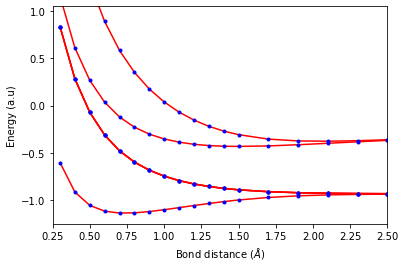

In [6]:
import matplotlib.pyplot as plt
n_excited_states = 5
x = [ t[0] for t in geom_vs_energies ]
for iex in range(n_excited_states + 1):
    e_ex = [ t[1][iex] for t in geom_vs_energies ]
    fci_ex = [ t[1][iex] for t in geom_vs_efci ]
    plt.plot(x, fci_ex, color='red')
    plt.plot(x, e_ex, '.', color='blue')

plt.ylabel('Energy (a.u)')
plt.xlabel('Bond distance ($\AA$)')

plt.xlim([0.25, 2.5])
plt.ylim([-1.25, 1.05])    
plt.show()

As expected, the potential energy surfaces show good agreement between the exact SciPy results and the VQD algorithm since after all we ran the latter on a noiseless state vector simulator as backend and the UCC ansatz is sufficiently expressive for H$_2$. 

We can plot the difference between the VQD and exact energies as shown below and find that for all except the highest energy state, the difference is in the sub micro-Hartree range.

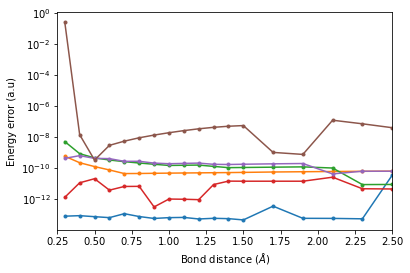

In [7]:
x = [ t[0] for t in geom_vs_energies ]
for iex in range(n_excited_states + 1):
    e_ex = [ t[1][iex] for t in geom_vs_energies ]
    fci_ex = [ t[1][iex] for t in geom_vs_efci ]
    d_ene = [ abs(e_ex[i] - fci_ex[i]) for i in range(len(geom_vs_efci))  ]
    plt.plot(x, d_ene, marker='.' )
plt.ylabel('Energy error (a.u)')
plt.xlabel('Bond distance ($\AA$)')
plt.xlim([0.25, 2.5])
plt.yscale('log')
plt.show()


## Additional Constraints

In many applications not all of the possible eigenstates are relevant and only a subset of useful states need to be calculated. Such states can often be selected by specifying symmetry constraints. Ideally, it would be possible to incorporate the constraints into the wavefuction ansatz iself which would lead to maximal resource savings but where that is impractical an explicit constrained optimization can be used instead. A nice feature of VQD is that it straightforwardly permits the incorporation of additional constraints during the optimization process to target only specific excited states. 

#### Spin-constrained VQD

In the code below we implement a total spin constraint to return states only in the spin singlet $(S = 0)$ sector of the 2 electron system and skip over the 3-fold degenerate triplet states of sto-3g H$_2$. To do so the VQD class defined above is simply extended to a **SpinConstrainedVQD** class which defines an expectation measurement for the $S^2$ operator when instantiated and the cost function **cost_fun_gen** is extended to include an additional penalty term that ensures the expectation of $S^2$ is 0. Note that since $S^2 \ge 0$ and we are targeting its lowest possible value we do not need to use a quadratic form to specify the constraint which would be the case in general [19]

In [8]:
class SpinConstrainedVQD(VQD):
    
    def __init__(self, qOps, wfnA, nEx, states=np.array([])):
        super().__init__(qOps, wfnA, nEx, states)
        
        # To implement explicit total Spin constraint use the S^2 operator 
        #from the set of available qubit operators.
        S2_op = self.qOps[2]
        exp_S2 = ExpectationFactory.build(operator=S2_op,backend=self.backend,include_custom=True)
        S2_meas = exp_S2.convert(StateFn(S2_op, is_measurement=True))
        self.expect_S2 = S2_meas.compose(self.wf_circ_op).reduce()
            
    def cost_fun_gen(self, params):
        """
        Function that evalues the cost function for deflation
        ----Parameters-----
        params: parameters of the wf circuit ansatz as a list
        """
        # Create a params dict from the provided list
        p_vec = list(self.wf_circ_op.parameters)[0].vector
        p_dict = {p_vec: params}

        # Evaluate the Hamiltonian expectation value for the current parameter set using the saved diag measrement obj
        ev = self.get_expectation(self.expect_op, p_dict)
        
        # Evaluate the S^2 expectation value for total spin constraint
        S2_ev = self.get_expectation(self.expect_S2, p_dict)

        pen = 0
        for i in range(self.nFound):
            params_i = (self.wfn_params[:,i])
            p_dict_i = {p_vec: params_i}
            ovlp = self.get_overlap(self.wfnA, p_dict, p_dict_i)
            pen += self.LagM[0] * np.abs(ovlp)
            
        cost = np.real(ev) +  pen + 3 * np.real(S2_ev) #cost now includes additional penalty to force total spin towards 0.
        
        self.fcount += 1
        if self.fcount%50 == 0:
            print(f'cost, ev, pen, S2_ev is: {cost, ev, pen, S2_ev}')
        return cost        

We also define a **ConstrainedExcitedStateCalculator** which extends the **ExcitedStateCalculator** class above and over-rides the **quantum_solve** and **classical_solve** methods to handle the additional spin constraint. 

In [9]:
class ConstrainedExcitedStateCalculator(ExcitedStateCalculator):
    def __init__(self, geometry):
        super().__init__(geometry)        
        
    def quantum_solve(self, num_excited_states, guess_state_parameters=None):
        print(self.wf_ansatz)
        vqdi = SpinConstrainedVQD(self.q_ops, self.wf_ansatz, num_excited_states, states=guess_state_parameters )
        (eigenvalues, result_states) = vqdi.calculate()
        #add nuclear repulsion to electronic energy
        eigenvalues = [ x + self.mf_energy.nuclear_repulsion_energy for x in eigenvalues ]
        return (eigenvalues, result_states)
    
    def classical_solve(self, num_excited_states):
        #Extract relevant qubit operators
        hq_op = self.q_ops[0]  #Hamiltonian
        nq_op = self.q_ops[1]  #Number operator
        s2_op = self.q_ops[2]  #S^2 operator
        
        #extract matrix representations of qubit operators
        H_Mat = hq_op.to_matrix()
        N_Mat = nq_op.to_matrix()
        S2_Mat = s2_op.to_matrix()
        
        #diagonalize to extrant eigen energies and eigenfunctions
        omega, psi = sl.eigh(H_Mat)
        
        #evaluate matrix elements of operators in eigenbasis
        N_expect = np.dot(psi.conj().T,np.dot(N_Mat, psi))
        E_expect = np.dot(psi.conj().T,np.dot(H_Mat, psi))
        S2_expect = np.dot(psi.conj().T,np.dot(S2_Mat, psi))
        
        #collect energies corresponding to states with the correct number of electrons and total Spin
        c_eigs = []
        for i in range(N_Mat.shape[0]):
            if abs(N_expect[i,i] - np.sum(self.num_electrons)) < 1e-8 and abs(S2_expect[i,i]) < 1e-2:
                c_eigs.append(E_expect[i,i] + self.mf_energy.nuclear_repulsion_energy)
        c_eigs = np.real(np.array(c_eigs))
        return np.sort(c_eigs)[0:num_excited_states+1]
        

We can now run the spin-constrained version of the calculation. For this we set the total number of excited states to 2 which is what we are left with if we remove the 3-fold degenerate triplet in sto-3g H$_2$. In real applications the total number of available excited states far exceeds the number we are typically interested in and we do not need to worry about asking for too many states. 

In [10]:
n_excited_states = 2
counter = 0
geom_vs_energies = []

restart = False

if not restart:
    states_history = []  #store these in case we need to re-start
    
for bond_distance in [ 0.3 + i*0.1 for i in range(12) ] + [ 1.5 + i*0.2 for i in range(6) ]:
    #define molecular geometry 
    geometry = [["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]]
    
    #instantiate the solver
    
    pes = ConstrainedExcitedStateCalculator(geometry)
        
    if (not restart) and counter == 0:
        (eigenvalues, result_states) = pes.quantum_solve(n_excited_states, guess_state_parameters = np.array([]) )
    else:
        if restart:
            result_states = states_history[counter]
        (eigenvalues, result_states) = pes.quantum_solve(n_excited_states, guess_state_parameters = result_states)

    geom_vs_energies.append((bond_distance, eigenvalues))
    states_history.append(result_states)
    
    counter += 1

print(geom_vs_energies)


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-2.365727747165601, (-2.365727747165602+0j), 0, (2.6e-16+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -2.365727747165604, array([-9.51980032e-09,  2.50206506e-08, -2.05281239e-08, -2.45278659e-08,
        2.47776877e-02, -2.01856133e-08, -3.07248484e-08,  1.22916776e-08,
       -1.12323530e-08,  2.47776761e-02]))
cost, ev, pen, S2_ev is: (2.7066342549624327, (-0.8571009399145326+0j), 0.11675359895955272, (1.148993865305804+0j))
cost, ev, pen, S2_ev is: (-0.5410764509964795, (-0.6699331907462238+0j), 0.10760674126703809, (0.007083332827568747+0j))
cost, ev, pen, S2_ev is: (-0.6062111906111883, (-0.6062113387807002-0j), 2.611331817e-09, (4.8519393371e-08+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.6062113932075532, array([ 0.52382627, -0.03344303, -0.03349635,  0.52373116,  1.10875822,
        0.94073344,  1.40543601,  0.78020408,  0.05019774,  1.4896103 ]))
cost, ev, pen, S2_ev is: (2.690695278331183, (-1.1775061382413152+0j), 1.400819332472393, (0.822460694700035+0j))
cost, ev, pen, S2_ev is: (0.6769559323107082, (-1.8199507041039353+0j), 2.4960638231448793, (0.000280937756588075+0j))
cost, ev, pen, S2_ev is: (0.6362660975519142, (-2.3513293446348427+0j), 2.9871892454622717, (0.000135398908161713+0j))
cost, ev, pen, S2_ev is: (0.6342722626333533, (-2.3657277136172477+0j), 2.9999999662915817, (3.319673082e-09+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, 0.6342722626323468, array([0.98816037, 0.03731603, 0.9006677 , 1.33546044, 0.78869337,
       0.84937246, 0.70533127, 0.26021389, 0.66707114, 1.3419608 ]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -2.2370927319268983, array([ 5.46445236e-08,  8.11823524e-08,  3.96946168e-08,  4.75912980e-08,
        2.97138971e-02,  3.91781761e-09, -1.05152185e-08,  4.85304429e-08,
        8.81003911e-09,  2.97139255e-02]))
cost, ev, pen, S2_ev is: (-0.7109780613924793, (-0.7109780711720941+0j), 2.132786952e-09, (2.548942604e-09+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.7109780732178375, array([ 0.52379142, -0.03344615, -0.03349568,  0.52375989,  1.10877306,
        0.94074978,  1.40543543,  0.7802035 ,  0.05018573,  1.48961031]))
cost, ev, pen, S2_ev is: (0.7625902486212548, (-2.2157644580990117-0j), 2.9767330523583797, (0.000540551453962241+0j))
cost, ev, pen, S2_ev is: (0.7615480483732939, (-2.0333694271960927+0j), 2.778026958695088, (0.005630172291432909+0j))
cost, ev, pen, S2_ev is: (1.5814581627217783, (-1.6734565114395483+0j), 2.403557580450621, (0.28378569790356856+0j))
cost, ev, pen, S2_ev is: (0.5402514099346348, (0.5329911383045612+0j), 0.005952060744523878, (0.000436070295183236+0j))
cost, ev, pen, S2_ev is: (0.5377616037462226, (0.5377615919072304+0j), 1.120545084e-08, (2.11180474e-10+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, 0.5377616026959197, array([0.64497645, 0.14036074, 0.83153951, 0.84606837, 0.73850213,
       1.08300504, 0.94811189, 0.04346763, 0.76455523, 0.15705126]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -2.113514216308318, array([-3.03148942e-08,  2.00082165e-07,  2.20316288e-07,  5.20300548e-09,
        3.59522335e-02, -3.36523193e-08,  1.13355110e-07,  2.38697009e-07,
       -1.93066193e-08,  3.59523469e-02]))
cost, ev, pen, S2_ev is: (-0.7913540774332449, (-0.791354079425318+0j), 1.600699398e-09, (1.30457893e-10+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.7913540791787746, array([ 0.52379948, -0.0334588 , -0.03348918,  0.52376872,  1.10876173,
        0.94075124,  1.40543548,  0.78020357,  0.05018138,  1.48961032]))
cost, ev, pen, S2_ev is: (0.2431682127268282, (0.24307204902574414+0j), 8.208187327855799e-05, (4.693942601842e-06+0j))
cost, ev, pen, S2_ev is: (0.2431313311778816, (0.24313131421029577+0j), 1.1543657145e-08, (1.807976233e-09+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, 0.24313133117651614, array([0.64603383, 0.13902655, 0.83346203, 0.84867516, 0.73726121,
       1.08074276, 0.94753072, 0.04420423, 0.76305974, 0.1672016 ]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.998248024972279, array([-5.54246083e-08,  1.14501348e-06,  1.43038574e-06,  5.26106685e-08,
        4.35140894e-02, -4.21411167e-08,  1.13046496e-06,  1.48768532e-06,
        1.42205567e-08,  4.35142305e-02]))
cost, ev, pen, S2_ev is: (-0.8454608213268576, (-0.8454608227759195+0j), 9.005450190000001e-10, (1.82838982e-10+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8454608220988498, array([ 0.52379113, -0.03346369, -0.0334879 ,  0.52377041,  1.10876361,
        0.9407468 ,  1.40543575,  0.78020383,  0.05018147,  1.48961032]))
cost, ev, pen, S2_ev is: (0.008187538157088683, (0.008070133031540356+0j), 9.2175810822585e-05, (8.409771575248e-06+0j))
cost, ev, pen, S2_ev is: (0.008122654579068788, (0.008122646881041876+0j), 2.4207843810000002e-09, (1.759080844e-09+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, 0.008122654577366968, array([0.64731711, 0.1374067 , 0.83581268, 0.85184424, 0.73578246,
       1.07797895, 0.9467832 , 0.04510959, 0.76125911, 0.17961098]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.8921568961115454, (-1.892156896600136-0j), 0, (1.62863557e-10+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.8921568961104989, array([-1.00951362e-07,  2.76814982e-06,  3.25746795e-06,  1.06898713e-07,
        5.24183801e-02, -4.99438280e-08,  2.90620740e-06,  3.46173017e-06,
        1.85493957e-08,  5.24185495e-02]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.876419347445908, array([ 0.52379242, -0.03346652, -0.03348375,  0.52377755,  1.10875878,
        0.94074871,  1.40543563,  0.78020371,  0.05018148,  1.48961034]))
cost, ev, pen, S2_ev is: (-0.16751187036788762, (-0.17748845725034385+0j), 0.008978668656690423, (0.000332639408588601+0j))
cost, ev, pen, S2_ev is: (-0.17265256279361887, (-0.1726536405666577-0j), 3.52826527161e-07, (2.41648837217e-07+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.17265333755265594, array([0.6488318 , 0.13552893, 0.83853359, 0.85556765, 0.73408792,
       1.07473194, 0.94589991, 0.04618092, 0.7591666 , 0.19419426]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.7956191774100339, (-1.7956191774957047+0j), 0, (2.8556915e-11+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.795619177408738, array([-1.23713093e-08,  1.19786262e-06,  1.16519299e-06,  5.54105960e-08,
        6.27393076e-02,  2.34146740e-08,  1.40342284e-06,  1.40661839e-06,
       -6.88187840e-08,  6.27394293e-02]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8893957482731535, array([ 0.52378907, -0.03346942, -0.03348313,  0.52377766,  1.10875945,
        0.94074616,  1.40543579,  0.78020387,  0.05018142,  1.48961034]))
cost, ev, pen, S2_ev is: (-0.2974718891028155, (-0.3177965529283512+0j), 0.018421053654016653, (0.000634536723839682+0j))
cost, ev, pen, S2_ev is: (-0.30918621861227014, (-0.30918715684143466+0j), 1.8588097470599998e-07, (2.50782729933e-07+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.3091869396426099, array([0.65060836, 0.13338212, 0.84166027, 0.85989347, 0.73217008,
       1.07096542, 0.94485338, 0.04743632, 0.75676865, 0.21116164]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.7085349573684274, (-1.7085349575860929+0j), 0, (7.2555167e-11+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.7085349573672914, array([-2.56368278e-08,  1.88002391e-06,  1.86739038e-06,  1.70110203e-08,
        7.45781687e-02,  1.64929152e-08,  2.24006899e-06,  2.21105755e-06,
       -5.14112368e-08,  7.45782687e-02]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8896806835083408, array([ 0.52378986, -0.03347138, -0.03348104,  0.5237811 ,  1.10875686,
        0.94074694,  1.40543574,  0.78020382,  0.05018119,  1.48961033]))
cost, ev, pen, S2_ev is: (-0.38987961276824495, (-0.4252271763649757+0j), 0.03215624365243744, (0.001063773314764436+0j))
cost, ev, pen, S2_ev is: (-0.41209268108193525, (-0.4120935099294566+0j), 7.151919447e-08, (2.52442775636e-07+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.41209335512888445, array([0.65266755, 0.13095403, 0.84519691, 0.86485736, 0.73004258,
       1.0666386 , 0.94362534, 0.04889486, 0.75404736, 0.23068262]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.6303275383451026, (-1.6303275383964515+0j), 0, (1.7116317e-11+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.6303275383439817, array([-7.29348930e-08,  7.62684334e-07,  7.71566754e-07, -9.05060921e-09,
        8.80847715e-02,  6.73771242e-09,  1.19851058e-06,  1.20249632e-06,
       -6.28924696e-08,  8.80849307e-02]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8814678369063701, array([ 0.52378817, -0.03347277, -0.0334809 ,  0.52378116,  1.10875729,
        0.94074583,  1.40543581,  0.7802039 ,  0.05018099,  1.48961033]))
cost, ev, pen, S2_ev is: (-0.452387974616381, (-0.5085167787743794+0j), 0.05118424271285138, (0.001648187148382356+0j))
cost, ev, pen, S2_ev is: (-0.4901289004285918, (-0.4901296986403109+0j), 1.6847811024e-08, (2.60454636026e-07+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.4901295750093592, array([0.65504399, 0.12823208, 0.849168  , 0.87052069, 0.72770795,
       1.06170353, 0.9421897 , 0.05058276, 0.75099066, 0.25300681]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.560263134179055, (-1.5602631342777513+0j), 0, (3.2898791e-11+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.560263134178062, array([-6.14439303e-08,  1.07565495e-06,  1.06886355e-06, -2.52084221e-09,
        1.03418246e-01,  2.96661628e-08,  1.63137572e-06,  1.63963937e-06,
       -2.45040999e-08,  1.03418386e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8675854359419038, array([ 0.52378851, -0.03347388, -0.03347996,  0.52378299,  1.10875604,
        0.94074635,  1.40543581,  0.78020389,  0.05018064,  1.48961037]))
cost, ev, pen, S2_ev is: (-0.4899422894372737, (-0.5737249740063178-0j), 0.07650756482183624, (0.002425039915735963+0j))
cost, ev, pen, S2_ev is: (-0.5493707302473706, (-0.5493715977389116+0j), 7.581894614999998e-09, (2.86636548796e-07+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.549371486079467, array([0.65777769, 0.12519769, 0.85359298, 0.87695256, 0.72517843,
       1.05609785, 0.94051555, 0.05253371, 0.74757791, 0.27842914]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.4977217531591458, (-1.4977217531838982-0j), 0, (8.250783e-12+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.4977217531582472, array([-1.19331618e-08,  3.71173598e-07,  3.42835341e-07,  1.35984809e-08,
        1.20637334e-01,  3.35203546e-08,  9.56431557e-07,  9.82669888e-07,
       -1.18085251e-08,  1.20637409e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8498414183354196, array([ 0.52378768, -0.03347461, -0.03347997,  0.52378297,  1.1087563 ,
        0.94074581,  1.40543585,  0.78020393,  0.05018045,  1.48961037]))
cost, ev, pen, S2_ev is: (-0.5064305756023261, (-0.6243279256385355+0j), 0.10773460209570225, (0.003387582646835711+0j))
cost, ev, pen, S2_ev is: (-0.5936944395623681, (-0.5936954855607964-0j), 3.9347591361e-08, (3.35550278969e-07+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.593695369397919, array([0.660895  , 0.12186141, 0.85845952, 0.88417922, 0.72248835,
       1.04980429, 0.93857923, 0.05476953, 0.74382272, 0.30706737]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.4422456577311777, (-1.4422456577653813-0j), 0, (1.1401211e-11+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.4422456577304392, array([-1.49855656e-08,  4.28181665e-07,  4.09503598e-07,  1.30018131e-08,
        1.39644072e-01,  1.63746434e-08,  1.10888243e-06,  1.13899174e-06,
       -1.64635537e-08,  1.39644074e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8294614144966819, array([ 0.52378768, -0.03347461, -0.03347997,  0.52378297,  1.1087563 ,
        0.94074581,  1.40543585,  0.78020393,  0.05018045,  1.48961037]))
cost, ev, pen, S2_ev is: (-0.6255043577701859, (-0.6256794402608343+0j), 0.00013876903888195802, (1.2104483922171e-05+0j))
cost, ev, pen, S2_ev is: (-0.6256629486267414, (-0.625662949501583+0j), 8.74815087e-10, (8.815e-15+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.62566294862674, array([0.66439656, 0.11827234, 0.86370923, 0.89216554, 0.71969893,
       1.0428636 , 0.93637288, 0.05728929, 0.73977868, 0.3387779 ]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.3934519701820938, (-1.3934519701897963+0j), 0, (2.567473e-12+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.3934519701814994, array([-4.80163305e-08, -4.68045077e-08, -7.04717279e-08, -4.48851741e-08,
        1.60142510e-01, -2.98965702e-08,  7.38841288e-07,  7.60673723e-07,
       -6.11228844e-08,  1.60142594e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.8073674828878817, array([ 0.52378768, -0.03347461, -0.03347997,  0.52378297,  1.1087563 ,
        0.94074581,  1.40543585,  0.78020393,  0.05018045,  1.48961037]))
cost, ev, pen, S2_ev is: (-0.6470187717772258, (-0.6472212244136462+0j), 0.00016244799350165998, (1.3334880972902e-05+0j))
cost, ev, pen, S2_ev is: (-0.6472050287328522, (-0.6472050292639516+0j), 5.310863429999999e-10, (4.344e-15+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.6472050287328532, array([0.66824678, 0.11448185, 0.86922156, 0.9007864 , 0.71690603,
       1.03538578, 0.9339162 , 0.06009161, 0.73552855, 0.37310097]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.3509341600445326, (-1.3509341600527744+0j), 0, (2.747282e-12+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.3509341600440923, array([-2.65683227e-08, -1.11676607e-07, -1.06310657e-07, -2.03676373e-08,
        1.81656765e-01,  4.19421025e-09,  8.08128215e-07,  8.02733232e-07,
        1.98812729e-08,  1.81656930e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.7842977165353721, array([ 0.52378768, -0.03347461, -0.03347997,  0.52378297,  1.1087563 ,
        0.94074581,  1.40543585,  0.78020393,  0.05018045,  1.48961037]))
cost, ev, pen, S2_ev is: (-0.6597713668606571, (-0.6599924098927803+0j), 0.00017939059311353097, (1.3884146336553e-05+0j))
cost, ev, pen, S2_ev is: (-0.6599773123706552, (-0.6599773126552836+0j), 2.84509716e-10, (3.9557e-14+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.6599773123706627, array([0.672378  , 0.11061261, 0.87484737, 0.90984485, 0.71420922,
       1.02755147, 0.93124508, 0.06311161, 0.73119096, 0.40924075]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.2827073904295931, (-1.2827073913199265+0j), 0, (2.96777779e-10+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.2827073904280697, array([-1.71532447e-08,  3.01825080e-06,  3.00555973e-06,  3.04147091e-08,
        2.25196872e-01,  2.53587392e-08,  4.68015050e-06,  4.67117814e-06,
        2.89190398e-08,  2.25197040e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.7374724685619527, array([ 0.52378768, -0.03347461, -0.03347997,  0.52378297,  1.1087563 ,
        0.94074581,  1.40543585,  0.78020393,  0.05018045,  1.48961037]))
cost, ev, pen, S2_ev is: (-0.6642901111019456, (-0.6651978057645053+0j), 0.0007515313017878011, (5.2054453590619e-05+0j))
cost, ev, pen, S2_ev is: (-0.6651509428162065, (-0.6651509467452611+0j), 3.907907963999999e-09, (7.048897e-12+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.6651509428162461, array([0.68110393, 0.1031638 , 0.88579641, 0.92818514, 0.70955427,
       1.01170426, 0.92558942, 0.06952473, 0.72284115, 0.48265135]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.2328531729512504, (-1.2328531729520984+0j), 0, (2.82657e-13+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.2328531729504766, array([-4.13937991e-08, -1.09313772e-06, -1.02306541e-06, -3.38400713e-08,
        2.65483729e-01,  8.73701223e-08,  1.06797516e-06,  1.07681020e-06,
       -6.84974663e-08,  2.65483997e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.69226319924458, array([ 0.52378732, -0.03347571, -0.03347845,  0.52378532,  1.10875478,
        0.94074566,  1.40543584,  0.78020393,  0.05018091,  1.48961036]))
cost, ev, pen, S2_ev is: (0.0011679132459438135, (-0.780530942643649+0j), 0.7100039781872448, (0.023898292567449325+0j))
cost, ev, pen, S2_ev is: (-0.6518491118616595, (-0.6518588734815596+0j), 1.570922014851e-06, (2.730232628433e-06+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.6518580062944915, array([0.68957366, 0.09665882, 0.89536713, 0.94522188, 0.70607082,
       0.99714912, 0.91999396, 0.07576507, 0.71555743, 0.5508996 ]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.1963638286222156, (-1.1963638286373395+0j), 0, (5.04132e-12+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.1963638286218656, array([-1.54988849e-07, -7.53553021e-07, -8.34906585e-07,  5.24348531e-08,
        2.99189842e-01,  4.23286175e-08,  1.58326549e-06,  1.47352900e-06,
       -1.36552712e-08,  2.99190136e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.6503947078921334, array([ 0.52378732, -0.03347571, -0.03347845,  0.52378532,  1.10875478,
        0.94074566,  1.40543584,  0.78020393,  0.05018091,  1.48961036]))
cost, ev, pen, S2_ev is: (-0.6280252683348176, (-0.628547714592896+0j), 0.000440823242560689, (2.7207671839242e-05+0j))
cost, ev, pen, S2_ev is: (-0.6285295052221438, (-0.6285295057979012+0j), 4.28059128e-10, (4.9232756e-11+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.628529505222353, array([0.69697163, 0.09149038, 0.90296976, 0.95953321, 0.70373575,
       0.98507895, 0.91503977, 0.08121306, 0.70977855, 0.60814871]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.1689994340796503, (-1.1689994340809617-0j), 0, (4.37099e-13+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.1689994340794758, array([ 7.68657315e-08, -1.41031574e-06, -1.07685903e-06, -1.37413226e-07,
        3.25499607e-01,  2.43482085e-07,  9.67107045e-07,  1.11588485e-06,
       -1.81878371e-07,  3.25499933e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.6125715784497021, array([ 0.52378732, -0.03347571, -0.03347845,  0.52378532,  1.10875478,
        0.94074566,  1.40543584,  0.78020393,  0.05018091,  1.48961036]))
cost, ev, pen, S2_ev is: (-0.6007434793978036, (-0.6010551760977827+0j), 0.00026428621070556, (1.5803496424527e-05+0j))
cost, ev, pen, S2_ev is: (-0.6010452743155518, (-0.6010452745490821+0j), 1.09257435e-10, (4.1424313e-11+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(2, -0.6010452743157533, array([0.70295718, 0.08762151, 0.90865441, 0.97074823, 0.70226593,
       0.97573481, 0.91099691, 0.08561154, 0.70546018, 0.65289505]))
     ┌────────────────────────────────────────────────────────────────┐
q_0: ┤0                                                               ├
     │                                                                │
q_1: ┤1                                                               ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]) │
q_2: ┤2                                                               ├
     │                                                                │
q_3: ┤3                                                               ├
     └────────────────────────────────────────────────────────────────┘
cost, ev, pen, S2_ev is: (-1.147725804290258, (-1.147725804295635+0j), 0, (1.792322e-12+0j))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(0, -1.1477258042901786, array([-3.00446996e-07, -9.39787481e-07, -1.24727826e-06,  2.10900972e-07,
        3.45199873e-01, -2.49420784e-08,  1.44515520e-06,  1.14252307e-06,
        1.99861415e-08,  3.45200180e-01]))


For MacOS, python >= 3.8, using only current process. Multiple core use not supported.


index, eigenValue, eigenVector:(1, -0.578889879130707, array([ 0.52378732, -0.03347571, -0.03347845,  0.52378532,  1.10875478,
        0.94074566,  1.40543584,  0.78020393,  0.05018091,  1.48961036]))
cost, ev, pen, S2_ev is: (-0.5727979518031818, (-0.5729695717125265+0j), 0.000145956183198279, (8.554575382136e-06+0j))
cost, ev, pen, S2_ev is: (-0.5729643661212271, (-0.572964366218204-0j), 2.3418473999999996e-11, (2.4519472e-11+0j))
index, eigenValue, eigenVector:(2, -0.5729643661213802, array([0.70756753, 0.08481608, 0.9127711 , 0.9791747 , 0.70136241,
       0.96878644, 0.90786763, 0.08899005, 0.70233427, 0.68641917]))
[(0.3, [-0.601803710765604, 1.157712643192447, 2.398196299032347]), (0.4, [-0.9141497046268983, 0.6119649540821626, 1.8607046299959196]), (0.5, [-1.0551597944683178, 0.2670003426612254, 1.3014857530165163]), (0.6000000000000001, [-1.1162860067722788, 0.03650119610115021, 0.8900846727773669]), (0.7, [-1.13618945193907, -0.1204519032744793, 0.5833141066187728]), (0.8, [-

In [11]:
n_excited_states = 2
counter = 0
geom_vs_efci = []
    
for bond_distance in [ 0.3 + i*0.1 for i in range(12) ] + [ 1.5 + i*0.2 for i in range(6) ]:
    #define molecular geometry 
    geometry = [["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]]
    
    #instantiate the solver
    
    pes = ConstrainedExcitedStateCalculator(geometry)
    fci_eigs = pes.classical_solve(n_excited_states)

    geom_vs_efci.append((bond_distance, fci_eigs))
    
    counter += 1

print(geom_vs_efci)


[(0.3, array([-0.60180371,  1.15771263,  2.64874383])), (0.4, array([-0.9141497 ,  0.61196495,  1.86070463])), (0.5, array([-1.05515979,  0.26700034,  1.30148575])), (0.6000000000000001, array([-1.11628601,  0.0365012 ,  0.89008467])), (0.7, array([-1.13618945, -0.1204519 ,  0.5833141 ])), (0.8, array([-1.13414767, -0.22792423,  0.35228457])), (0.9000000000000001, array([-1.12056028, -0.301706  ,  0.17588132])), (1.0, array([-1.10115033, -0.35229063,  0.03904763])), (1.1, array([-1.07919294, -0.38651524, -0.0683013 ])), (1.2, array([-1.05674075, -0.40886041, -0.15271436])), (1.3, array([-1.03518627, -0.42240202, -0.21860355])), (1.4000000000000001, array([-1.01546825, -0.42938376, -0.26922131])), (1.5, array([-0.99814935, -0.43151291, -0.3071925 ])), (1.7, array([-0.97142669, -0.42619176, -0.35387022])), (1.9, array([-0.95433885, -0.41374888, -0.37334368])), (2.1, array([-0.94437468, -0.39840556, -0.37654036])), (2.3, array([-0.93892239, -0.38249453, -0.37096823])), (2.5, array([-0.936

Plotting the calculated energies we see that we have skipped over the triplet excited states as intended and see only  the three spin siglet states.

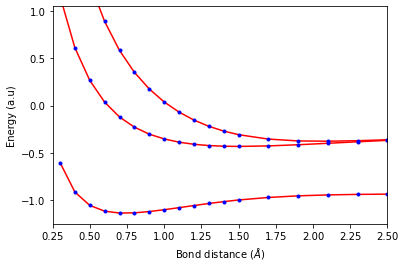

In [12]:
import matplotlib.pyplot as plt

x = [ t[0] for t in geom_vs_energies ]
for iex in range(n_excited_states + 1):
    e_ex = [ t[1][iex] for t in geom_vs_energies ]
    fci_ex = [ t[1][iex] for t in geom_vs_efci ]
    plt.plot(x, fci_ex, color='red')
    plt.plot(x, e_ex, '.', color='blue')

plt.ylabel('Energy (a.u)')
plt.xlabel('Bond distance ($\AA$)')

plt.xlim([0.25, 2.5])
plt.ylim([-1.25, 1.05])    
plt.show()

Plot the energy differences between the exact and spin-constrained VQD solutions, we see that the additional constraint slightly increases the error as the optimization problem gets harder for the classical optimizer but agreement is still in the sub micro-Hartree range.

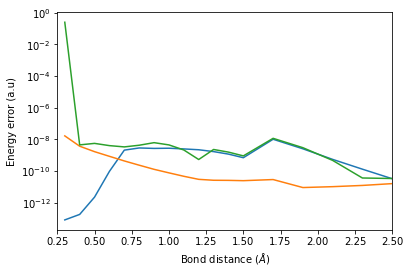

In [13]:
x = [ t[0] for t in geom_vs_energies ]
for iex in range(n_excited_states + 1):
    e_ex = [ t[1][iex] for t in geom_vs_energies ]
    fci_ex = [ t[1][iex] for t in geom_vs_efci ]
    d_ene = [ abs(e_ex[i] - fci_ex[i]) for i in range(len(geom_vs_efci))  ]
    plt.plot(x, d_ene )

plt.ylabel('Energy error (a.u)')
plt.xlabel('Bond distance ($\AA$)')

plt.xlim([0.25, 2.5])
plt.yscale('log')
plt.show()

That concludes this VQD mini-tutorial. The code provided above should be easily adaptable for exploring other symmetry constraints as well as other molecular systems. Feedback on possible bugs/suggestions for improvement are most welcome!

### Cited References

1. 	Chen, H., Nusspickel, M., Tilly, J., Booth, G.H.: A variational quantum eigensolver for dynamic correlation functions. Phys. Rev. A. 104, 032405 (2021). https://doi.org/10.1103/PhysRevA.104.032405
2. 	Zhang, F., Gomes, N., Yao, Y., Orth, P.P., Iadecola, T.: Adaptive variational quantum eigensolvers for highly excited states. Phys. Rev. B. 104, 075159 (2021). https://doi.org/10.1103/PhysRevB.104.075159
3. 	Tilly, J., Jones, G., Chen, H., Wossnig, L., Grant, E.: Computation of molecular excited states on IBM quantum computers using a discriminative variational quantum eigensolver. Phys. Rev. A. 102, 062425 (2020). https://doi.org/10.1103/PhysRevA.102.062425
4. 	Yordanov, Y.S., Barnes, C.H.W., Arvidsson-Shukur, D.R.M.: Molecular excited state calculations with the QEB-ADAPT-VQE. ArXiv210606296 Quant-Ph. (2021)
5. 	Rizzo, J., Libbi, F., Tacchino, F., Ollitrault, P.J., Marzari, N., Tavernelli, I.: One-particle Green’s functions from the quantum equation of motion algorithm. ArXiv220101826 Quant-Ph. (2022)
6. 	Ollitrault, P.J., Kandala, A., Chen, C.-F., Barkoutsos, P.K., Mezzacapo, A., Pistoia, M., Sheldon, S., Woerner, S., Gambetta, J., Tavernelli, I.: Quantum equation of motion for computing molecular excitation energies on a noisy quantum processor. Phys. Rev. Res. 2, 043140 (2020). https://doi.org/10.1103/PhysRevResearch.2.043140
7. 	Bierman, J., Li, Y., Lu, J.: Quantum Orbital Minimization Method for Excited States Calculation on Quantum Computer. ArXiv220107963 Phys. Physicsquant-Ph. (2022)
8. 	Nakanishi, K.M., Mitarai, K., Fujii, K.: Subspace-search variational quantum eigensolver for excited states. Phys. Rev. Res. 1, 033062 (2019). https://doi.org/10.1103/PhysRevResearch.1.033062
9. 	Bauman, N.P., Liu, H., Bylaska, E.J., Krishnamoorthy, S., Low, G.H., Granade, C.E., Wiebe, N., Baker, N.A., Peng, B., Roetteler, M., Troyer, M., Kowalski, K.: Towards quantum computing for high-energy excited states in molecular systems: quantum phase estimations of core-level states. ArXiv200706185 Phys. Physicsquant-Ph. (2020)
10. 	LaRose, R., Tikku, A., O’Neel-Judy, É., Cincio, L., Coles, P.J.: Variational Quantum State Diagonalization. Npj Quantum Inf. 5, 57 (2019). https://doi.org/10.1038/s41534-019-0167-6
11. 	Higgott, O., Wang, D., Brierley, S.: Variational Quantum Computation of Excited States. Quantum. 3, 156 (2019). https://doi.org/10.22331/q-2019-07-01-156
12. 	Peruzzo, A., McClean, J., Shadbolt, P., Yung, M.-H., Zhou, X.-Q., Love, P.J., Aspuru-Guzik, A., O’Brien, J.L.: A variational eigenvalue solver on a photonic quantum processor. Nat. Commun. 5, 4213 (2014). https://doi.org/10.1038/ncomms5213
13. 	Tilly, J., Chen, H., Cao, S., Picozzi, D., Setia, K., Li, Y., Grant, E., Wossnig, L., Rungger, I., Booth, G.H., Tennyson, J.: The Variational Quantum Eigensolver: a review of methods and best practices. ArXiv211105176 Quant-Ph. (2021)
14. 	Excited states solvers — Qiskit Nature 0.3.1 documentation, https://qiskit.org/documentation/nature/tutorials/04_excited_states_solvers.html
15. 	Operator Flow — Qiskit 0.34.2 documentation, https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html
16. 	Qiskit, https://qiskit.org/
17. 	Qiskit Nature Documentation — Qiskit Nature 0.3.1 documentation, https://qiskit.org/documentation/nature/
18. 	Lee, J., Huggins, W.J., Head-Gordon, M., Whaley, K.B.: Generalized Unitary Coupled Cluster Wave functions for Quantum Computation. J. Chem. Theory Comput. 15, 311–324 (2019). https://doi.org/10.1021/acs.jctc.8b01004
19. 	Kuroiwa, K., Nakagawa, Y.O.: Penalty methods for a variational quantum eigensolver. Phys. Rev. Res. 3, 013197 (2021). https://doi.org/10.1103/PhysRevResearch.3.013197